## COCO bounding boxes to YOLO format

In [90]:
import json
import os
from PIL import Image

def convert_coco_to_yolo(coco_annotation_file, output_folder, images_folder):
    with open(coco_annotation_file, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(output_folder, exist_ok=True)

    # Get all annotations
    image_annotations = {}
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        class_id = annotation['category_id'] - 1  # YOLO class index start by 0, COCO by 1
        
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append((bbox, class_id))
    
    for image in coco_data['images']:
        image_id = image['id']
        image_filename = image['file_name']
        
        # Get image dimensions to normalize bounding boxes coordinates
        image_path = os.path.join(images_folder, image_filename)
        with Image.open(image_path) as img:
            image_width, image_height = img.size
        
        # YOLO annotation filename
        base_filename = os.path.splitext(image_filename)[0]
        output_file = os.path.join(output_folder, f'{base_filename}.txt')
        
        # Create YOLO annotation file
        if image_id in image_annotations:
            with open(output_file, 'w') as f:
                for bbox, class_id in image_annotations[image_id]:
                    # COCO coordinates
                    x_min, y_min, box_width, box_height = bbox
                    
                    # Convert to YOLO coordinates
                    x_center = (x_min + box_width / 2) / image_width
                    y_center = (y_min + box_height / 2) / image_height
                    yolo_width = box_width / image_width
                    yolo_height = box_height / image_height
                    
                    yolo_annotation = f'{class_id} {x_center:.6f} {y_center:.6f} {yolo_width:.6f} {yolo_height:.6f}'
                    f.write(yolo_annotation + "\n")
    
    print(f'Done. Saved YOLO annotation at {output_folder}')

In [91]:
coco_annotation_file = 'dataset/annotations/annotations.json'
images_folder = 'dataset/archive'
output_folder = 'dataset/YOLO_annotation'

convert_coco_to_yolo(coco_annotation_file, output_folder, images_folder)

Done. Saved YOLO annotation at dataset/YOLO_annotation


## MMPose

### Inference
https://mmpose.readthedocs.io/en/latest/user_guides/inference.html

#### Utilizando detector e Pose Estimator dentro do MMPose
O MMPose é vinculado ao MMDetector, o que permite treinar um detector utilizando o MMDetector e utilizar em conjunto chamando apenas uma função.
Para exemplificar está sendo utilizado modelos pré-treinado do MMPose e MMDetection, mas basta subustituir o arquivo de configuração e dos pesos com um customizado.

In [3]:
from mmpose.apis import MMPoseInferencer
import time
import cv2

img_path = 'tests/data/coco/000000197388.jpg'
img = cv2.imread(img_path)

# https://mmpose.readthedocs.io/en/latest/user_guides/inference.html#arguments-of-inferencer
inferencer = MMPoseInferencer(
    pose2d='configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    pose2d_weights='https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    #det_model='whole_image',  # Not uses detection, run pose in the whole imagem
    #det_model='rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.py',
    det_weights='https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
    device='cuda'
)

# Create generator
result_generator = inferencer(
    img,  # OpenCV (BGR) or image path - One image/path or a list
    vis_out_dir='pred/vis_out_dir',  # Save imagens with keypoints (output)
    pred_out_dir='pred/pred_out_dir'  # Save JSONs with preditions (results)
)

09/26 15:59:15 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth
09/26 15:59:15 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth


In [2]:
results = next(result_generator)
results

09/26 15:59:12 - mmengine - INFO - the output image has been saved at pred/vis_out_dir/000000.jpg


/home/max/anaconda3/envs/mmpose/lib/python3.11/site-packages/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/max/anaconda3/envs/mmpose/lib/python3.11/site-packages/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/max/anaconda3/envs/mmpose/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


defaultdict(list,
            {'visualization': [],
             'predictions': [[{'keypoints': [[37.34320831298828,
                  79.07234954833984],
                 [39.493595123291016, 72.62118530273438],
                 [30.892047882080078, 74.77157592773438],
                 [43.794368743896484, 66.17002868652344],
                 [20.14011573791504, 70.4708023071289],
                 [50.24552536010742, 76.92195892333984],
                 [5.087409973144531, 85.52350616455078],
                 [73.8997802734375, 98.42582702636719],
                 [0.7866371273994446, 115.62892150878906],
                 [78.20055389404297, 91.97467041015625],
                 [2.937023639678955, 115.62892150878906],
                 [33.04243469238281, 145.7343292236328],
                 [5.087409973144531, 147.8847198486328],
                 [45.94475173950195, 190.8924560546875],
                 [2.937023639678955, 201.64437866210938],
                 [37.34320831298828, 242.5

In [4]:
for result in result_generator:
    print(result)

09/26 15:59:17 - mmengine - INFO - the output image has been saved at pred/vis_out_dir/000000.jpg
defaultdict(<class 'list'>, {'visualization': [], 'predictions': [[{'keypoints': [[37.34320831298828, 79.07234954833984], [39.493595123291016, 72.62118530273438], [30.892047882080078, 74.77157592773438], [43.794368743896484, 66.17002868652344], [20.14011573791504, 70.4708023071289], [50.24552536010742, 76.92195892333984], [5.087409973144531, 85.52350616455078], [73.8997802734375, 98.42582702636719], [0.7866371273994446, 115.62892150878906], [78.20055389404297, 91.97467041015625], [2.937023639678955, 115.62892150878906], [33.04243469238281, 145.7343292236328], [5.087409973144531, 147.8847198486328], [45.94475173950195, 190.8924560546875], [2.937023639678955, 201.64437866210938], [37.34320831298828, 242.50172424316406], [5.087409973144531, 251.103271484375]], 'keypoint_scores': [0.9436688423156738, 0.9260847568511963, 0.9494446516036987, 0.8321188688278198, 0.9174845218658447, 0.916952729225

/home/max/anaconda3/envs/mmpose/lib/python3.11/site-packages/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/max/anaconda3/envs/mmpose/lib/python3.11/site-packages/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [5]:
result

defaultdict(list,
            {'visualization': [],
             'predictions': [[{'keypoints': [[37.34320831298828,
                  79.07234954833984],
                 [39.493595123291016, 72.62118530273438],
                 [30.892047882080078, 74.77157592773438],
                 [43.794368743896484, 66.17002868652344],
                 [20.14011573791504, 70.4708023071289],
                 [50.24552536010742, 76.92195892333984],
                 [5.087409973144531, 85.52350616455078],
                 [73.8997802734375, 98.42582702636719],
                 [0.7866371273994446, 115.62892150878906],
                 [78.20055389404297, 91.97467041015625],
                 [2.937023639678955, 115.62892150878906],
                 [33.04243469238281, 145.7343292236328],
                 [5.087409973144531, 147.8847198486328],
                 [45.94475173950195, 190.8924560546875],
                 [2.937023639678955, 201.64437866210938],
                 [37.34320831298828, 242.5

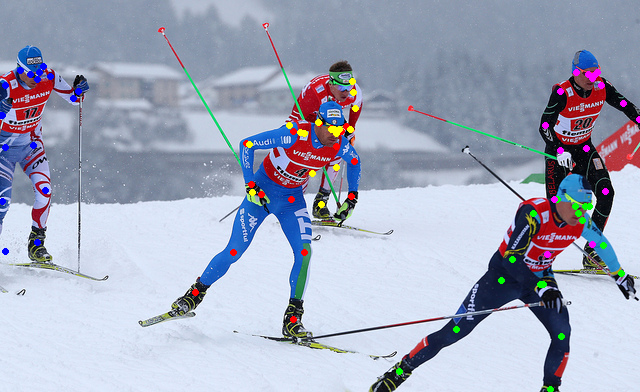

In [8]:
from PIL import Image
colors = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [0, 255, 255],
    [255, 0, 255]
]
for idx, prediction in enumerate(result['predictions'][0]):
    for keypoint in prediction['keypoints']:
        img = cv2.circle(img, (int(keypoint[0]), int(keypoint[1])), radius=2, color=colors[idx%len(colors)], thickness=2)
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Utilizando detector de objetos externo e Pose Estimator
Neste caso será utilizado o YOLO para detectar os objetos e o MMPose para detectar os Poses

In [9]:
from ultralytics import YOLO
model = YOLO('work_dirs/detector/best_yolov8n.pt')

img_path = 'dataset/archive/00a3dd76f.jpg'
img = cv2.imread(img_path)

results = model.predict(source=img,
                        conf=0.7,
                        iou=0.3,
                        imgsz=640,
                        show=False,
                        save=False,
                        verbose=False,
                       )
crops = []
for idx in range(len(results[0].boxes.cls)):
    if results[0].boxes.cls[idx] in [0, 1]:
        xyxy = results[0].boxes.xyxy[idx].cpu().numpy().astype(int)
        crops.append(img[xyxy[1]-20:xyxy[3]+20, xyxy[0]-20:xyxy[2]+20])

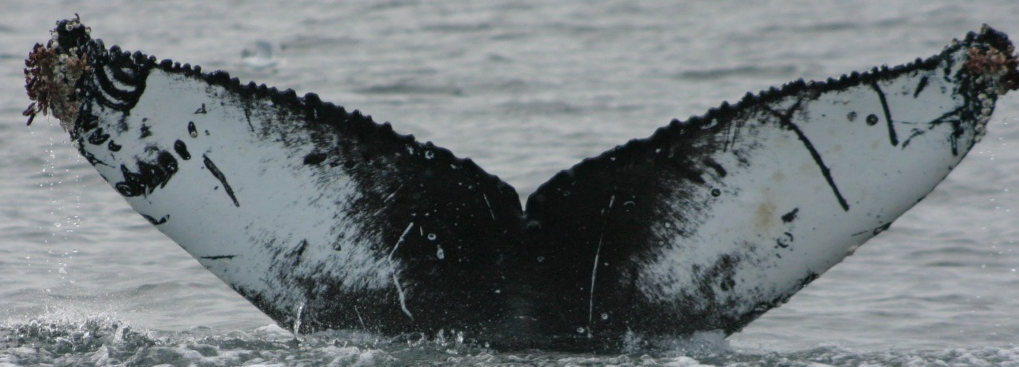

In [10]:
Image.fromarray(cv2.cvtColor(crops[0], cv2.COLOR_BGR2RGB))

In [11]:
from mmpose.apis import inference_topdown, init_model

# Init model
model = init_model(
    'work_dirs/td-hm_ViTPose-small_8xb64-210e_coco-256x192/td-hm_ViTPose-small_8xb64-210e_coco-256x192.py',
    'work_dirs/td-hm_ViTPose-small_8xb64-210e_coco-256x192/best_coco_AP_epoch_210.pth'
)

result = inference_topdown(model, crops[0])  # OpenCV (BGR) or image path - Only one image/path

Loads checkpoint by local backend from path: work_dirs/td-hm_ViTPose-small_8xb64-210e_coco-256x192/best_coco_AP_epoch_210.pth


In [12]:
result

[<PoseDataSample(
 
     META INFORMATION
     flip_indices: [4, 3, 2, 1, 0, 9, 8, 7, 6, 5]
     input_scale: array([     1273.8,      1698.3], dtype=float32)
     pad_shape: (256, 192)
     batch_input_shape: (256, 192)
     input_size: (192, 256)
     ori_shape: (367, 1019)
     img_shape: (367, 1019)
     input_center: array([      509.5,       183.5], dtype=float32)
     img_path: None
     dataset_name: 'coco'
 
     DATA FIELDS
     gt_instance_labels: <InstanceData(
         
             META INFORMATION
         
             DATA FIELDS
         ) at 0x7420ea00bb10>
     pred_instances: <InstanceData(
         
             META INFORMATION
         
             DATA FIELDS
             keypoint_scores: array([[    0.93149,     0.94711,     0.96135,     0.94276,     0.96521,     0.95437,     0.97649,     0.95718,     0.99884,     0.88074]], dtype=float32)
             bboxes: array([[          0,           0,        1019,         367]], dtype=float32)
             keypoints_

[     63.831      22.684]
[     507.49      185.27]
[     523.21      208.63]
[     539.03      185.47]
[     991.07      32.625]
[        982      134.68]
[     716.15      340.61]
[     520.08      345.22]
[     301.98      335.77]
[     53.969      131.18]


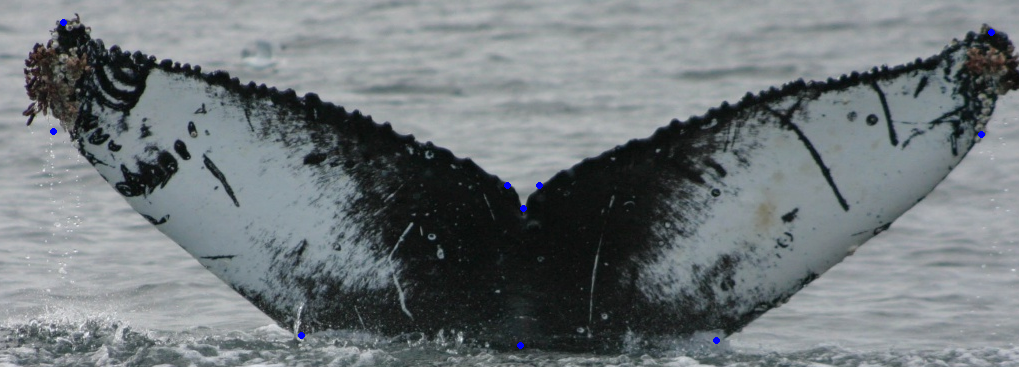

In [13]:
from PIL import Image
color = [255, 0, 0]
for keypoint in result[0].pred_instances['keypoints'][0]:
    print(keypoint)
    img_draw = cv2.circle(crops[0], (int(keypoint[0]), int(keypoint[1])), radius=2, color=color, thickness=2)
Image.fromarray(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))